
## Introdução

Este notebook apresenta um projeto de **Processamento de Linguagem Natural (NLP)** com foco na **análise de sentimentos em tweets**, utilizando um conjunto de dados rotulado da biblioteca **NLTK**. O objetivo é construir um pipeline completo de classificação de sentimentos, passando pelas etapas de limpeza dos textos, extração de características, treinamento e avaliação de um modelo de **Regressão Logística**.

---

## Etapas do Projeto

### Parte 1 - Importação e exploração do dataset

* Carregamento dos tweets com sentimentos positivos e negativos usando os recursos do NLTK.
* Análise inicial para entender o formato e a distribuição dos dados.

### Parte 2 - Pré-processamento dos textos

* Limpeza dos tweets (remoção de menções, URLs, hashtags, pontuação e símbolos).
* Tokenização, remoção de stopwords e aplicação de **stemming** para padronização das palavras.

### Parte 3 - Análise de frequência

* Contagem das palavras mais frequentes associadas a sentimentos positivos e negativos.
* Criação de um dicionário de frequências para alimentar o modelo de classificação.

### Parte 4 - Regressão logística

* Implementação da função sigmoide, da função de custo e do algoritmo de **gradiente descendente**.
* Definição do vetor de características para cada tweet.

### Parte 5 - Treinamento do modelo

* Aplicação do gradiente descendente para aprender os pesos (theta) do modelo.
* Exibição do custo final e dos pesos ajustados após o treinamento.

### Parte 6 - Testando o modelo

* Criação da função para prever o sentimento de um novo tweet com base nos pesos aprendidos.
* Utilização da função `predicao_tweet()` para estimar a probabilidade de sentimento positivo.

### Parte 7 - Verificar o desempenho usando o conjunto de teste

* Avaliação do modelo em dados não vistos.
* Cálculo da **acurácia** com base nas previsões feitas no conjunto de teste.

### Parte 8 - Teste seu próprio tweet

* Cédula simples para o usuário inserir seu próprio tweet e obter a previsão de sentimento feita pelo modelo.


##Importação das bibliotecas necessárias para criação do projeto

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import twitter_samples

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

## Parte 1 - Importação e exploração do dataset

In [89]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [47]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [48]:
print("Numeros de tweets positivos: " , len(all_positive_tweets))
print("Numeros de tweets negativos: ", len(all_negative_tweets) )

print("O tipo das variaveis 'all_positive_tweets/all_negative_tweets': ", type(all_positive_tweets))
print('O tipo dos objetos(tweets) dentro dessas variaveis ', type(all_positive_tweets[0]))

Numeros de tweets positivos:  5000
Numeros de tweets negativos:  5000
O tipo das variaveis 'all_positive_tweets/all_negative_tweets':  <class 'list'>
O tipo dos objetos(tweets) dentro dessas variaveis  <class 'str'>


In [49]:
# printando positivo em verde
print('\033[92m' + all_positive_tweets[np.random.randint(0,5000)])

# printando negativo em vermelho
print('\033[91m' + all_negative_tweets[np.random.randint(0,5000)])

An apartment makeover? http://t.co/ctLa1jppdb great ideas for factory living :)
didnt took photos with you :-(


##Parte 2 Pré-processamento dos textos

In [50]:
import re                                  # library for regular expression operations
import string                              # for string operations

Para essa parte utilizaremos steamming, remoção de stop words e tokenização das palavras, utilizaremos um tweet aleatorio como exemplo para ilustrar cada parte do processo

In [51]:
tweet = all_positive_tweets[2277]
print(tweet)

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i


In [52]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
def limpar_tweet(tweet):
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r'#', '', tweet)
  return tweet

#Guardaremos essa função pois quando for preciso fazer usa-lá para todo conjunto de dados chamaremos ela novamente

In [54]:
def pre_processamento(tweet):
  tweet = limpar_tweet(tweet)
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

  tweet_tokens = tokenizer.tokenize(tweet)

  stopwords_english = stopwords.words('english')

  tweet_clean = []
  for word in tweet_tokens:
    if (word not in stopwords_english and #remove stopwords
        word not in string.punctuation): #remove pontuação
      tweet_clean.append(word)
  return tweet_clean



In [55]:
print(tweet)
print(pre_processamento(tweet))

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i
['beautiful', 'sunflowers', 'sunny', 'friday', 'morning', ':)', 'sunflowers', 'favourites', 'happy', 'friday', '…']


In [56]:
def steamming(tweet_clean):
  stemmer = PorterStemmer()

  tweets_stem = []
  for word in tweet_clean:
    stem_word = stemmer.stem(word) # stemming palavra
    tweets_stem.append(stem_word)
  return tweets_stem



In [57]:
print(tweet)
print(pre_processamento(tweet))
print(steamming(pre_processamento(tweet)))

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i
['beautiful', 'sunflowers', 'sunny', 'friday', 'morning', ':)', 'sunflowers', 'favourites', 'happy', 'friday', '…']
['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


In [58]:
def pre_processamento_final(tweet):
  return steamming(pre_processamento(tweet))

##Parte 3 - Análise de frequência

In [75]:
def construcao_freqs(tweets, ys):
    """Construcao de frequencias.
    Input:
        tweets: uma lista de tweets
        ys: um array de m x 1 com a rotulagem de cada tweet (0,1)
    Output:
        freqs: um dicionário mapeando (palavra,rotulo) para a frequencia
    """
    # Converte o array np em lista, pois o zip precisa de um iterável.
    # o "squeeze" é necessário ou a lista acaba com um elemento.
    yslist = np.squeeze(ys).tolist()

    # Começa com dicionário vazio e vai populando conforme vai iterando
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in pre_processamento_final(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

##Parte 4 - Regressão logística

### Usando regressão logística para classificação de texto.

A função sigmoide é definida como:

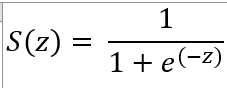


Ela mapeia a entrada (z) para um valor entre 0 e 1, podendo assim ser interpretada como uma probabilidade.

Implementação da função sigmoide:

- Você deve garantir que essa função funcione corretamente tanto se z for um valor escalar (ex: um número como 3.5) quanto se for um array (ex: uma lista ou vetor de valores).



In [60]:
def sigmoide(z):
    '''
    Entrada:
        z: valor de entrada (pode ser um escalar ou um array)
    Saída:
        h: o resultado da função sigmoide aplicada a z
    '''

    # calcula a função sigmoide de z
    h = 1 / (1 + np.exp(-z))

    return h


In [61]:
# Testando a função
if (sigmoide(0) == 0.5):
    print('SUCESSO!')
else:
    print('Oops!')

if (sigmoide(4.92) == 0.9927537604041685):
    print('CORRETO!')
else:
    print('Oops denovo!')

print(sigmoide(np.array([0, 4.92])))

SUCESSO!
CORRETO!
[0.5        0.99275376]


### Regressão Logística: regressão + função sigmoide

A **regressão logística** começa com uma **regressão linear comum** e, em seguida, aplica uma **função sigmoide** ao resultado dessa regressão.

#### Regressão Linear:

$$
z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_N x_N
$$

Observe que os valores de \$\theta\$ são os **pesos**.
Usaremos a notação \$\theta\$ para representar esses pesos.

#### Regressão Logística:

$$
h(z) = \frac{1}{1+\exp^{-z}}
$$

$$
z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_N x_N
$$

Chamaremos o valor `z` de **logits**.

---

Se quiser que eu converta isso diretamente em uma célula Markdown pronta para o Colab, posso te passar também.


### Parte 4.2  – Função de Custo e Gradiente

A **função de custo** usada na regressão logística é a **média da perda logarítmica (log loss)** em todos os exemplos de treinamento:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^m \left[ y^{(i)}\log (h(z(\theta)^{(i)})) + (1 - y^{(i)})\log (1 - h(z(\theta)^{(i)})) \right] \tag{5}
$$

Onde:

* $m$ é o número de exemplos de treinamento
* $y^{(i)}$ é o **rótulo real** do exemplo de número *i*
* $h(z(\theta)^{(i)})$ é a **previsão do modelo** para o exemplo *i*

---

#### Função de perda para um único exemplo:

$$
Loss = -1 \times \left[ y^{(i)}\log (h(z(\theta)^{(i)})) + (1 - y^{(i)})\log (1 - h(z(\theta)^{(i)})) \right]
$$

---

#### Observações importantes:

* Todos os valores de $h$ estão entre 0 e 1, então os logaritmos serão **negativos**. Por isso, usamos o fator **-1** para tornar a soma positiva.
* Quando o modelo prevê 1 ($h(z(\theta)) = 1$) e o rótulo $y$ também é 1, a perda é **zero**.
* O mesmo acontece se o modelo prevê 0 e o rótulo real também for 0: a perda será **zero**.
* No entanto, se o modelo prevê algo muito próximo de 1 ($h(z(\theta)) = 0.9999$) e o rótulo real é 0, o segundo termo da perda se torna um número muito **negativo**, e multiplicando por -1 resulta em uma **perda positiva alta**.

Exemplo:

$$
-1 \times (1 - 0) \times \log(1 - 0.9999) \approx 9.2
$$

👉 Quanto mais próximo de 1 for a previsão incorreta, **maior será a penalidade**.

In [62]:
# verifique que, quando o modelo prevê um valor próximo de 1, mas o rótulo real é 0, a perda é um valor positivo alto
-1 * (1 - 0) * np.log(1 - 0.9999)  # perda é aproximadamente 9.2


np.float64(9.210340371976294)

#### Atualização dos Pesos

Para atualizar o vetor de pesos $\theta$, aplicarei o **Gradiente Descendente** para melhorar iterativamente as previsões do modelo.

O gradiente da função de custo $J$ em relação a um dos pesos $\theta_j$ é dado por:

$$
\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)} - y^{(i)})x_j \tag{5}
$$

Onde:

* $i$ é o índice de cada um dos $m$ exemplos de treinamento
* $j$ é o índice do peso $\theta_j$, e $x_j$ é a característica (feature) associada a esse peso

---

Para atualizar o peso $\theta_j$, ajustamos seu valor **subtraindo uma fração do gradiente**, determinada pela taxa de aprendizado $\alpha$:

$$
\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta)
$$

* A **taxa de aprendizado** $\alpha$ é um valor escolhido manualmente e **controla o tamanho de cada atualização** dos pesos.

In [63]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Entrada:
        x: matriz de características (features), com dimensões (m, n+1)
        y: rótulos correspondentes à matriz de entrada x, dimensões (m, 1)
        theta: vetor de pesos com dimensão (n+1, 1)
        alpha: taxa de aprendizado
        num_iters: número de iterações que você deseja treinar seu modelo
    Saída:
        J: custo final
        theta: vetor de pesos final
    Dica: você pode querer imprimir o custo para garantir que ele está diminuindo.
    '''
    ### INÍCIO DO CÓDIGO ###
    # obtém 'm', o número de linhas da matriz x
    m = x.shape[0]

    for i in range(0, num_iters):

        # calcula z, o produto escalar de x e theta
        z = np.dot(x, theta)

        # calcula h, a função sigmoide aplicada a z
        h = sigmoide(z)

        # calcula a função de custo
        # note que também poderíamos usar np.array.transpose() ao invés de np.array.T
        # np.array.T apenas deixa o código mais legível :)
        J = -1./m * (np.dot(y.T, np.log(h)) + np.dot((1 - y).T, np.log(1 - h)))

        # atualiza os pesos theta
        theta = theta - (alpha/m) * np.dot(x.T, (h - y))

    ### FIM DO CÓDIGO ###
    J = float(J)
    return J, theta


In [64]:
# Verifica a função
# Constrói um caso de teste sintético usando funções de geração de números aleatórios do numpy
np.random.seed(1)  # Define a semente para reprodução dos resultados

# A entrada X é uma matriz 10 x 3 com uns na primeira coluna para o termo de bias
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)

# Os rótulos Y são uma matriz 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Aplica o gradiente descendente
tmp_J, tmp_theta = gradientDescent(tmp_X, tmp_Y, np.zeros((3, 1)), 1e-8, 700)

# Imprime o custo após o treinamento
print(f"O custo após o treinamento é {tmp_J:.8f}.")

# Imprime o vetor de pesos resultante
print(f"O vetor resultante de pesos é {[round(t, 8) for t in np.squeeze(tmp_theta)]}")


O custo após o treinamento é 0.67094970.
O vetor resultante de pesos é [np.float64(4.1e-07), np.float64(0.00035658), np.float64(7.309e-05)]


<ipython-input-63-dde2da729d09>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


In [67]:
def extract_features(tweet, freqs):
    '''
    Entrada:
        tweet: uma lista de palavras (tokens) de um tweet
        freqs: um dicionário com a contagem de vezes que (palavra, label) aparece.

    Saída:
        x: um vetor de características com dimensão (1,3)
           [1, contagem_palavras_positivas, contagem_palavras_negativas]
    '''

    # processa o tweet (remove stopwords, faz stemming, etc.)
    word_l = pre_processamento_final(tweet)

    # cria um vetor de características com 3 posições
    x = np.zeros((1, 3))

    # o primeiro valor é sempre 1 (termo de viés/bias)
    x[0,0] = 1

    # percorre todas as palavras processadas do tweet
    for word in word_l:

        # se a palavra aparecer com o rótulo positivo (1.0) no dicionário, soma a frequência
        if (word, 1.0) in freqs:
            x[0,1] += freqs[(word, 1.0)]

        # se a palavra aparecer com o rótulo negativo (0.0), soma a frequência também
        if (word, 0.0) in freqs:
            x[0,2] += freqs[(word, 0.0)]

    return x


## Parte 5 - Treinamento do modelo

In [68]:
#separando em teste e treino do modelo
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg
test_x = test_pos + test_neg

In [72]:
# combina rotulos positivos e negativos
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)


In [73]:
# Imprime o shape
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


In [76]:
freqs = construcao_freqs(train_x, train_y)

print('type(freqs) = '+str(type(freqs)))
print('len(freqs)= '+str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs)= 11306


In [79]:
# test the function below
print('Exemplo de um tweet positivo: \n', train_x[0])
print('\nExemplo de um tweet após ser processado: \n', pre_processamento_final(train_x[0]))

Exemplo de um tweet positivo: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

Exemplo de um tweet após ser processado: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


In [80]:
X = np.zeros((len(train_x),3))
for i in range(len(train_x)):
  X[i, :] = extract_features(train_x[i], freqs)

Y = train_y

J , theta = gradientDescent(X, Y, np.zeros((3,1)), 1e-9, 1500)

print(f"O custo após o treinamento é {J:.8f}.")
print(f"O vetor resultante de pesos é {[round(t, 8) for t in np.squeeze(theta)]}")


O custo após o treinamento é 0.24217224.
O vetor resultante de pesos é [np.float64(7e-08), np.float64(0.00052352), np.float64(-0.00055579)]


<ipython-input-63-dde2da729d09>:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  J = float(J)


## Parte 6 - Testando modelo

In [81]:
# UNQ_C4 (IDENTIFICADOR ÚNICO DA CÉLULA, NÃO EDITAR)
def predicao_tweet(tweet, freqs, theta):
    '''
    Entrada:
        tweet: uma string (o texto do tweet)
        freqs: um dicionário com a frequência de cada tupla (palavra, rótulo)
        theta: vetor de pesos de dimensão (3,1)

    Saída:
        y_pred: a probabilidade do tweet ser positivo (ou negativo)
    '''
    ### INÍCIO DO CÓDIGO ###

    # extrai as características do tweet e armazena em x
    x = extract_features(tweet, freqs)

    # faz a previsão usando x e theta (produto escalar e função sigmoide)
    y_pred = sigmoide(np.dot(x, theta))

    ### FIM DO CÓDIGO ###

    return y_pred


In [82]:
# Exemplo para testar a predicao
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predicao_tweet(tweet, freqs, theta)))

I am happy -> 0.518562
I am bad -> 0.494329
this movie should have been great. -> 0.515312
great -> 0.515449
great great -> 0.530868
great great great -> 0.546228
great great great great -> 0.561501


<ipython-input-82-5ac626e7c0f5>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print( '%s -> %f' % (tweet, predicao_tweet(tweet, freqs, theta)))


In [83]:
meu_tweet = 'I am learning :)'
predicao_tweet(meu_tweet, freqs, theta)

array([[0.8162007]])


##  Parte 7 - Verificar o desempenho usando o conjunto de teste

Depois de treinar o seu modelo com o conjunto de treinamento, é hora de verificar **como ele se comporta com dados reais e inéditos**, testando-o com o conjunto de teste.

---

###  Instruções: Implemente a função `test_logistic_regression`

O objetivo é **calcular a acurácia** (percentual de acertos) do seu modelo de regressão logística usando os dados de teste e os pesos `theta` que você treinou.

---

###  Etapas para implementar:

1. Para cada tweet do conjunto de teste, use a função `predict_tweet()` para fazer a **previsão de probabilidade**.

2. Se a **probabilidade prevista for maior que 0.5**, você considera que o modelo classificou o tweet como **positivo** (ou seja, `y_hat = 1`).
   Caso contrário, a classificação é **negativa** (`y_hat = 0`).

3. Compare a previsão `y_hat` com o valor real do rótulo (`test_y`).

4. Conte **quantas vezes a previsão foi correta**, ou seja, `y_hat == test_y`.

5. Calcule a acurácia:

   $$
   \text{acurácia} = \frac{\text{número de acertos}}{m}
   $$

   onde `m` é o número total de exemplos no conjunto de teste.


In [84]:
def testar_regressao_logistica(test_x, test_y, freqs, theta):
    """
    Entrada:
        test_x: uma lista de tweets
        test_y: vetor (m, 1) com os rótulos reais correspondentes a cada tweet
        freqs: um dicionário com a frequência de cada par (palavra, rótulo)
        theta: vetor de pesos com dimensão (3, 1)
    Saída:
        acuracia: (número de tweets classificados corretamente) / (número total de tweets)
    """

    # lista para armazenar as previsões
    y_hat = []

    for tweet in test_x:
        # obter a previsão do rótulo para o tweet
        y_pred = predicao_tweet(tweet, freqs, theta)

        if y_pred > 0.5:
            # adicionar 1.0 à lista se for positivo
            y_hat.append(1)
        else:
            # adicionar 0 se for negativo
            y_hat.append(0)

    # y_hat é uma lista e test_y é um array (m,1)
    # converter ambos para arrays unidimensionais para comparar com o operador '=='
    acuracia = (y_hat == np.squeeze(test_y)).sum() / len(test_x)

    return acuracia


In [85]:
tmp_accuracy = testar_regressao_logistica(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9965


##Parte 8 - Teste seu próprio tweet

In [87]:
# Pode se sentir livre para mudar o tweet abaixo
my_tweet = 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(pre_processamento_final(my_tweet))
y_hat = predicao_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else:
    print('Negative sentiment')

['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']
[[0.48136088]]
Negative sentiment
